In [20]:
import matplotlib.pyplot as plt
from itertools import product

In [54]:
import numpy as np

def sinkhorn_with_polarization(C, a, b, P, P_max, epsilon, lambda_p, dual_lr=0.01, precision=1e-5, max_iter=5000):
    """
    Sinkhorn algorithm with polarization constraint.
    
    Args:
        C (ndarray): Cost matrix.
        a (ndarray): Marginal distribution for rows.
        b (ndarray): Marginal distribution for columns.
        P (ndarray): Polarization scores for columns.
        P_max (float): Maximum allowable polarization.
        epsilon (float): Entropic regularization parameter.
        lambda_p (float): Polarization penalty weight.
        dual_lr (float): Learning rate for dual variable (kappa).
        precision (float): Convergence threshold.
        max_iter (int): Maximum number of iterations.
        
    Returns:
        P_opt (ndarray): Optimal transport plan.
        polarization_history (list): Evolution of polarization over iterations.
        kappa (float): Final dual variable for polarization constraint.
    """
    n, m = C.shape
    K = np.exp(-C / epsilon)  # Initialize Gibbs kernel
    u = np.ones((n, 1))  # Row scaling factors
    v = np.ones((m, 1))  # Column scaling factors
    kappa = 0  # Dual variable for polarization constraint
    polarization_history = []

    for iteration in range(max_iter):
        # Update scaling factors
        u = a / np.maximum(K @ v, 1e-300)  # Avoid division by zero
        v = b / np.maximum(K.T @ u, 1e-300)
        
        # Compute transport plan
        P_opt = np.diagflat(u.flatten()) @ K @ np.diagflat(v.flatten())
        
        # Compute total polarization
        total_polarization = np.sum(P_opt * P[np.newaxis, :])
        polarization_history.append(total_polarization)
        
        # Update dual variable for polarization constraint
        if total_polarization > P_max:
            polarization_violation = total_polarization - P_max
            kappa += dual_lr * polarization_violation
        
        # Update cost matrix and kernel
        C_adjusted = C + lambda_p * P[np.newaxis, :] + kappa * P[np.newaxis, :]
        K = np.exp(-C_adjusted / epsilon)
        
         # Convergence check
        norm_diff = np.abs(np.sum(P_opt) - np.sum(a))
        if norm_diff < precision and abs(total_polarization - P_max) <=  0.025:
            print(f"Converged at iteration {iteration} with norm_diff = {norm_diff:.2e} and total_polarization = {total_polarization:.2e}.")
            break
    else:
        print(f"Reached maximum iterations ({max_iter}) with norm_diff = {norm_diff:.2e} and total_polarization = {total_polarization:.2e}.")

    return P_opt, polarization_history, kappa


In [55]:
def parameter_tuning(C, a, b, P, parameter_grid, precision=1e-2, max_iter=5000):
    """
    Tune parameters for the Sinkhorn algorithm with polarization.

    Args:
        C (ndarray): Cost matrix.
        a (ndarray): Marginal distribution for rows.
        b (ndarray): Marginal distribution for columns.
        P (ndarray): Polarization scores for columns.
        parameter_grid (dict): Parameter grid with lists of possible values.
        precision (float): Convergence threshold.
        max_iter (int): Maximum number of iterations.

    Returns:
        results (list): List of results for each parameter combination.
    """
    results = []
    param_combinations = list(product(
        parameter_grid['epsilon'],
        parameter_grid['lambda_p'],
        parameter_grid['dual_lr'],
        parameter_grid['P_max']
    ))

    for epsilon, lambda_p, dual_lr, P_max in param_combinations:
        print(f"Testing parameters: epsilon={epsilon}, lambda_p={lambda_p}, dual_lr={dual_lr}, P_max={P_max}")
        
        P_opt, polarization_history, kappa = sinkhorn_with_polarization(
            C, a, b, P, P_max, epsilon, lambda_p, dual_lr, precision, max_iter
        )
        
        # Log results
        norm_diff = np.abs(np.sum(P_opt) - np.sum(a))
        final_polarization = polarization_history[-1]
        converged = (norm_diff < precision)

        results.append({
            'epsilon': epsilon,
            'lambda_p': lambda_p,
            'dual_lr': dual_lr,
            'P_max': P_max,
            'iterations': len(polarization_history),
            'final_polarization': final_polarization,
            'norm_diff': norm_diff,
            'converged': converged
        })

        print(f"  Result: {'Converged' if converged else 'Did not converge'}, "
              f"Iterations: {len(polarization_history)}, "
              f"Final Polarization: {final_polarization:.4f}, "
              f"Norm Diff: {norm_diff:.4e}")

    return results


In [56]:
# Example setup
n_users = 500
n_content = 400
np.random.seed(42)

# Generate distributions and polarization scores
a = np.random.rand(n_users, 1)
a /= a.sum()
b = np.random.rand(n_content, 1)
b /= b.sum()
C = np.random.rand(n_users, n_content)  # Cost matrix
P = np.random.rand(n_content)  # Polarization scores

# Constraints and regularization
P_max = 0.1
epsilon = 0.05
lambda_p = 10.0
dual_lr = 0.5

# Define parameter grid
parameter_grid = {
    'epsilon': [0.05, 0.1, 0.2],
    'lambda_p': [10.0, 20.0, 50.0],
    'dual_lr': [0.01, 0.1, 0.5],
    'P_max': [P_max] # We don't want to grid over this! O.W for some parameters the distance to of "Final polarization" will be lower
}



In [57]:
# Extract subsample data
a_subsample = a[subsample_user_indices]
b_subsample = b[subsample_content_indices]
C_subsample = C[np.ix_(subsample_user_indices, subsample_content_indices)]
P_subsample = P[subsample_content_indices]

# Re-normalize the subsampled distributions
a_subsample /= a_subsample.sum()
b_subsample /= b_subsample.sum()

# Ensure consistent scaling of epsilon and lambda_p
epsilon_scaled = epsilon / 2  # Adjust this as needed for subsample scaling
lambda_p_scaled = lambda_p / 2  # Adjust based on the effect you observe

# Step 2: Perform parameter tuning on subsample with scaled parameters
parameter_grid = {
    'epsilon': [epsilon_scaled, epsilon],  # Including both scaled and original values
    'lambda_p': [lambda_p_scaled, lambda_p, lambda_p * 2],
    'dual_lr': [0.01, 0.1, 0.5],
    'P_max': [P_max]
}

results = parameter_tuning(C_subsample, a_subsample, b_subsample, P_subsample, parameter_grid)

Testing parameters: epsilon=0.025, lambda_p=5.0, dual_lr=0.01, P_max=0.1
Reached maximum iterations (5000) with norm_diff = 3.44e-01 and total_polarization = 2.42e-01.
  Result: Did not converge, Iterations: 5000, Final Polarization: 0.2423, Norm Diff: 3.4363e-01
Testing parameters: epsilon=0.025, lambda_p=5.0, dual_lr=0.1, P_max=0.1
Reached maximum iterations (5000) with norm_diff = 5.61e-01 and total_polarization = 1.03e-01.
  Result: Did not converge, Iterations: 5000, Final Polarization: 0.1029, Norm Diff: 5.6118e-01
Testing parameters: epsilon=0.025, lambda_p=5.0, dual_lr=0.5, P_max=0.1
Reached maximum iterations (5000) with norm_diff = 5.86e-01 and total_polarization = 9.13e-02.
  Result: Did not converge, Iterations: 5000, Final Polarization: 0.0913, Norm Diff: 5.8578e-01
Testing parameters: epsilon=0.025, lambda_p=10.0, dual_lr=0.01, P_max=0.1
Reached maximum iterations (5000) with norm_diff = 4.21e-01 and total_polarization = 1.84e-01.
  Result: Did not converge, Iterations: 5

In [58]:
def select_with_tolerance(results, tau_norm, tau_polarization):
    """
    Select the best parameters with a relaxed convergence criterion.

    Args:
        results (list): List of results with metrics for each parameter combination.
        tau_norm (float): Tolerance threshold for Norm Diff.
        tau_polarization (float): Tolerance threshold for polarization error.

    Returns:
        best_result (dict): Best parameter set based on the lowest polarization error.
    """
    # Filter results within the tolerance thresholds
    filtered_results = [
        x for x in results
        if x['norm_diff'] <= tau_norm and abs(x['final_polarization'] - x['P_max']) <= tau_polarization
    ]
    
    if not filtered_results:
        print("No parameter combination satisfies the relaxed convergence criteria.")
        return None

    # Minimize polarization error among filtered results
    best_result = min(filtered_results, key=lambda x: abs(x['final_polarization'] - x['P_max']))
    return best_result

# Set relaxed convergence thresholds
tau_norm = 6e-1  # Example threshold for Norm Diff
tau_polarization = 0.025  # Example threshold for polarization error

# Select the best parameters based on the relaxed criteria
best_result = select_with_tolerance(results, tau_norm, tau_polarization)

if best_result:
    print("\nBest Parameters:")
    print(f"Epsilon: {best_result['epsilon']}")
    print(f"Lambda_p: {best_result['lambda_p']}")
    print(f"Dual Learning Rate: {best_result['dual_lr']}")
    print(f"P_max: {best_result['P_max']}")
    print(f"Iterations: {best_result['iterations']}")
    print(f"Final Polarization: {best_result['final_polarization']}")
    print(f"Norm Diff: {best_result['norm_diff']}")
    print(f"Converged: {best_result['converged']}")


Best Parameters:
Epsilon: 0.025
Lambda_p: 5.0
Dual Learning Rate: 0.1
P_max: 0.1
Iterations: 5000
Final Polarization: 0.10287535278827396
Norm Diff: 0.56117988437819
Converged: False


In [60]:
# Same function as above but saving the error history:
def sinkhorn_with_polarization_errors(C, a, b, P, P_max, epsilon, lambda_p, dual_lr=0.01, precision=1e-5, max_iter=5000):
    """
    Sinkhorn algorithm with polarization constraint.
    
    Args:
        C (ndarray): Cost matrix.
        a (ndarray): Marginal distribution for rows.
        b (ndarray): Marginal distribution for columns.
        P (ndarray): Polarization scores for columns.
        P_max (float): Maximum allowable polarization.
        epsilon (float): Entropic regularization parameter.
        lambda_p (float): Polarization penalty weight.
        dual_lr (float): Learning rate for dual variable (kappa).
        precision (float): Convergence threshold.
        max_iter (int): Maximum number of iterations.
        
    Returns:
        P_opt (ndarray): Optimal transport plan.
        polarization_history (list): Evolution of polarization over iterations.
        norm_diff_history (list): Evolution of norm difference over iterations.
        kappa (float): Final dual variable for polarization constraint.
    """
    n, m = C.shape
    K = np.exp(-C / epsilon)  # Initialize Gibbs kernel
    u = np.ones((n, 1))  # Row scaling factors
    v = np.ones((m, 1))  # Column scaling factors
    kappa = 0  # Dual variable for polarization constraint

    polarization_history = []
    norm_diff_history = []

    for iteration in range(max_iter):
        # Update scaling factors
        u = a / np.maximum(K @ v, 1e-300)  # Avoid division by zero
        v = b / np.maximum(K.T @ u, 1e-300)
        
        # Compute transport plan
        P_opt = np.diagflat(u.flatten()) @ K @ np.diagflat(v.flatten())
        
        # Compute total polarization
        total_polarization = np.sum(P_opt * P[np.newaxis, :])
        polarization_history.append(total_polarization)
        
        # Compute norm difference
        norm_diff = np.abs(np.sum(P_opt) - np.sum(a))
        norm_diff_history.append(norm_diff)
        
        # Update dual variable for polarization constraint
        if total_polarization > P_max:
            polarization_violation = total_polarization - P_max
            kappa += dual_lr * polarization_violation
        
        # Update cost matrix and kernel
        C_adjusted = C + lambda_p * P[np.newaxis, :] + kappa * P[np.newaxis, :]
        K = np.exp(-C_adjusted / epsilon)
        
        # Convergence check
        if norm_diff < precision and abs(total_polarization - P_max) <= 0.025:
            print(f"Converged at iteration {iteration} with norm_diff = {norm_diff:.2e} and total_polarization = {total_polarization:.2e}.")
            break
    else:
        print(f"Reached maximum iterations ({max_iter}) with norm_diff = {norm_diff:.2e} and total_polarization = {total_polarization:.2e}.")

    return P_opt, polarization_history, norm_diff_history, kappa


In [61]:
# Check if best_result is available
if best_result:
    # Extract parameters from best_result
    epsilon = best_result['epsilon']
    lambda_p = best_result['lambda_p']
    dual_lr = best_result['dual_lr']
    P_max = best_result['P_max']
    
    # Run Sinkhorn algorithm with polarization constraint using the best parameters
    P_opt, polarization_history, norm_diff_history, kappa = sinkhorn_with_polarization_errors(
        C, a, b, P, P_max, epsilon, lambda_p, dual_lr
    )
    
  # Print results
    print("\nFinal Results Using Best Parameters:")
    print(f"Optimal Transport Plan: \n{P_opt}")
    print(f"Polarization History: {polarization_history}")
    print(f"Final Kappa: {kappa}")
    print(f"Final Polarization: {polarization_history[-1]}")
else:
    print("No suitable parameter combination found.")


Reached maximum iterations (5000) with norm_diff = 5.36e-01 and total_polarization = 1.01e-01.

Final Results Using Best Parameters:
Optimal Transport Plan: 
[[6.39484544e-08 0.00000000e+00 0.00000000e+00 ... 4.52019728e-06
  3.64939877e-17 1.74855439e-17]
 [1.87511687e-04 0.00000000e+00 0.00000000e+00 ... 3.37411263e-06
  1.95738245e-22 2.36409766e-14]
 [8.51420162e-21 0.00000000e+00 0.00000000e+00 ... 5.48113229e-15
  1.11677998e-19 8.46675559e-12]
 ...
 [2.49939989e-17 0.00000000e+00 0.00000000e+00 ... 6.01961114e-19
  1.19868094e-21 4.01062083e-21]
 [3.36722796e-19 0.00000000e+00 0.00000000e+00 ... 1.93358177e-05
  6.88436731e-08 8.25373801e-06]
 [4.37987720e-14 0.00000000e+00 0.00000000e+00 ... 7.35212737e-14
  7.24640126e-22 1.00833733e-16]]
Polarization History: [0.496132522423514, 0.49613252242351413, 0.496132522423514, 0.4961325224235141, 0.4961325224235141, 0.496132522423514, 0.496132522423514, 0.49613252242351413, 0.496132522423514, 0.4961325224235139, 0.496132522423514, 0.4

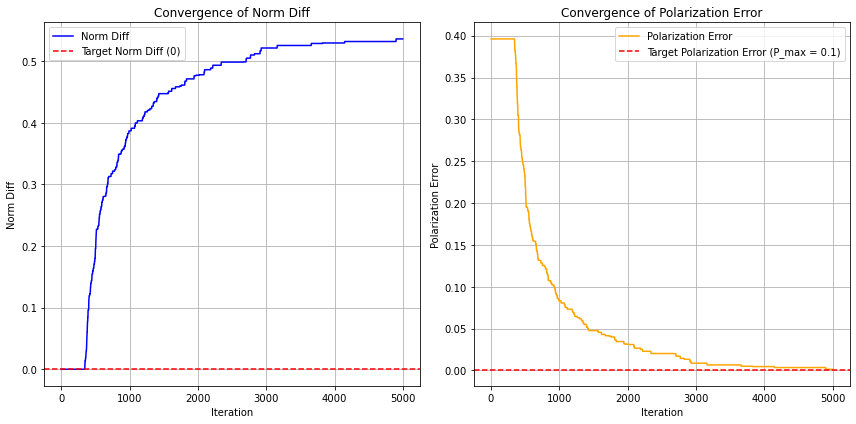

In [ ]:
# Visualize the trade-off between Norm Diff and Polarization Error

plt.figure(figsize=(12, 6))

# Plot Norm Diff
plt.subplot(1, 2, 1)
plt.plot(norm_diff_history, label='Norm Diff', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Target Norm Diff (0)')
plt.xlabel('Iteration')
plt.ylabel('Norm Diff')
plt.title('Convergence of Norm Diff')
plt.grid(True)
plt.legend()

# Plot Polarization Error
polarization_errors = [abs(p - P_max) for p in polarization_history]
plt.subplot(1, 2, 2)
plt.plot(polarization_errors, label='Polarization Error', color='orange')
plt.axhline(y=0, color='red', linestyle='--', label=f'Target Polarization Error (P_max = {P_max})')
plt.xlabel('Iteration')
plt.ylabel('Polarization Error')
plt.title('Convergence of Polarization Error')
plt.grid(True)
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()